# **1. Perkenalan Dataset**


**Personalized Learning & Adaptive Education Dataset**

Dalam dunia pendidikan digital, memahami pola belajar siswa menjadi tantangan utama dalam menciptakan sistem pembelajaran adaptif. Dataset Personalized Learning & Adaptive Education ini dirancang untuk mendukung pengembangan model AI yang mampu mengelompokkan siswa berdasarkan pola keterlibatan dan performa mereka tanpa menggunakan label eksplisit.

Sumber Data: https://www.kaggle.com/datasets/adilshamim8/personalized-learning-and-adaptive-education-dataset/data

**Fitur Dataset**

Dataset ini mencakup berbagai aspek penting dari aktivitas siswa dalam platform pembelajaran online, termasuk:

- Interaksi dengan Konten: Waktu yang dihabiskan menonton video, jumlah percobaan kuis, dan keterlibatan dalam forum diskusi.

- Kinerja Akademik: Skor kuis, tingkat penyelesaian tugas, dan hasil ujian akhir.

- Profil & Preferensi Belajar: Usia, tingkat pendidikan, serta gaya belajar (Visual, Auditori, dll.).

**Pendekatan dalam Proyek**

Karena dataset ini tidak boleh memiliki label eksplisit saat klasifikasi, pendekatan yang digunakan adalah:

1. Clustering untuk Mengelompokkan Siswa

  - Menggunakan algoritma seperti K-Means, DBSCAN, atau Gaussian Mixture Model (GMM) untuk mengelompokkan siswa berdasarkan pola keterlibatan dan performa mereka.

  - Menentukan jumlah cluster optimal dengan metode seperti Silhouette Score atau Elbow Method.

  - Kolom Dropout Likelihood akan **dihapus** sebelum clustering agar tidak mempengaruhi hasil dan tetap mengikuti metode unsupervised learning.

2. Klasifikasi Berdasarkan Hasil Clustering

  - Setelah clustering selesai, hasilnya akan digunakan sebagai label baru untuk melatih model supervised seperti Random Forest, SVM, atau Neural Networks.

  - Model ini akan digunakan untuk memprediksi kelompok siswa baru berdasarkan pola yang telah ditemukan dalam clustering.

**Fitur yang Digunakan untuk Clustering**

Untuk memastikan clustering mencerminkan pola belajar siswa, fitur utama yang akan digunakan meliputi:
  - Engagement Metrics (Seberapa aktif siswa?) → Time Spent on Videos, Quiz Attempts, Forum Participation, Assignment Completion Rate
  - Performance Metrics (Seberapa baik performanya?) → Quiz Scores, Final Exam Score
  - Learning Preferences (Bagaimana gaya belajarnya?) → Learning Style
  - Demographics (Siapa mereka? Untuk analisis lebih lanjut) → Age, Education Level

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import umap

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Personalized Learning/personalized_learning_dataset.csv')
df.head()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No


**Menghapus Label (Dropout_Likelhood)**

In [67]:
df.drop(columns=['Dropout_Likelihood'], inplace=True)

In [68]:
df.head()

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3


**Kolom Dropout Likelihood telah dihapus**

# **4. Exploratory Data Analysis (EDA)**

EDA bertujuan untuk memahami karakteristik dataset sebelum melakukan analisis lebih lanjut. Pada tahap ini, kita akan mengeksplorasi struktur data, distribusi data, korelasi antar variabel, serta karakteristik variabel numerik dan kategorikal menggunakan statistik deskriptif dan visualisasi.

## Struktur Data dan Missing Values

In [69]:
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

Jumlah baris: 10000
Jumlah kolom: 14


In [70]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Student_ID                  10000 non-null  object
 1   Age                         10000 non-null  int64 
 2   Gender                      10000 non-null  object
 3   Education_Level             10000 non-null  object
 4   Course_Name                 10000 non-null  object
 5   Time_Spent_on_Videos        10000 non-null  int64 
 6   Quiz_Attempts               10000 non-null  int64 
 7   Quiz_Scores                 10000 non-null  int64 
 8   Forum_Participation         10000 non-null  int64 
 9   Assignment_Completion_Rate  10000 non-null  int64 
 10  Engagement_Level            10000 non-null  object
 11  Final_Exam_Score            10000 non-null  int64 
 12  Learning_Style              10000 non-null  object
 13  Feedback_Score              10000 non-null  int

Dataset ini terdiri dari **10.000 entri** dengan **14 kolom**, mencakup informasi demografi, keterlibatan, dan performa siswa dalam platform pembelajaran online.

- **Fitur Numerik (8 kolom)**: Usia, waktu belajar, jumlah percobaan kuis, skor kuis & ujian, partisipasi forum, tingkat penyelesaian tugas, dan skor umpan balik.

- **Fitur Kategorikal (6 kolom)**: Gender, tingkat pendidikan, nama kursus, tingkat keterlibatan, gaya belajar, dan ID siswa.

In [71]:
print("\nMissing values per kolom:")
print(df.isnull().sum())


Missing values per kolom:
Student_ID                    0
Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score                0
dtype: int64


Tidak ditemukan adanya missing values

## Distribusi Fitur Numerik

### Statistik Deskriptif Fitur Numerik

In [72]:
print(df.describe())

                Age  Time_Spent_on_Videos  Quiz_Attempts   Quiz_Scores  \
count  10000.000000          10000.000000   10000.000000  10000.000000   
mean      32.137700            255.375400       2.500500     64.578600   
std       10.062647            141.656392       1.122642     20.289125   
min       15.000000             10.000000       1.000000     30.000000   
25%       24.000000            131.000000       1.000000     47.000000   
50%       32.000000            257.000000       3.000000     65.000000   
75%       41.000000            378.000000       4.000000     82.000000   
max       49.000000            499.000000       4.000000     99.000000   

       Forum_Participation  Assignment_Completion_Rate  Final_Exam_Score  \
count         10000.000000                10000.000000      10000.000000   
mean             24.616200                   69.546800         64.697000   
std              14.330305                   17.360782         20.096417   
min               0.000000   

Dataset ini memiliki **8 fitur numerik**, masing-masing dengan distribusi berikut:

- **Age**: Usia siswa berkisar antara 15 hingga 49 tahun, dengan rata-rata 32 tahun.

- **Time Spent on Videos**: Rata-rata waktu belajar 255 menit, dengan rentang 10–499 menit.

- **Quiz Attempts**: Siswa mencoba kuis rata-rata 2-3 kali, dengan maksimum 4 kali.

- **Quiz Scores & Final Exam Score**: Skor kuis rata-rata 64,6%, sedangkan ujian akhir 64,7%, dengan skor tertinggi 99%.

- **Forum Participation**: Partisipasi rata-rata 24 posting, dengan siswa paling aktif mencapai 49 posting.

- **Assignment Completion Rate**: Sebagian besar siswa menyelesaikan 70% tugas, dengan beberapa hampir 100%.

- **Feedback Score**: Penilaian kursus rata-rata 3 dari 5, dengan variasi dari 1 hingga 5.

### Histogram untuk Distribusi Fitur Numerik

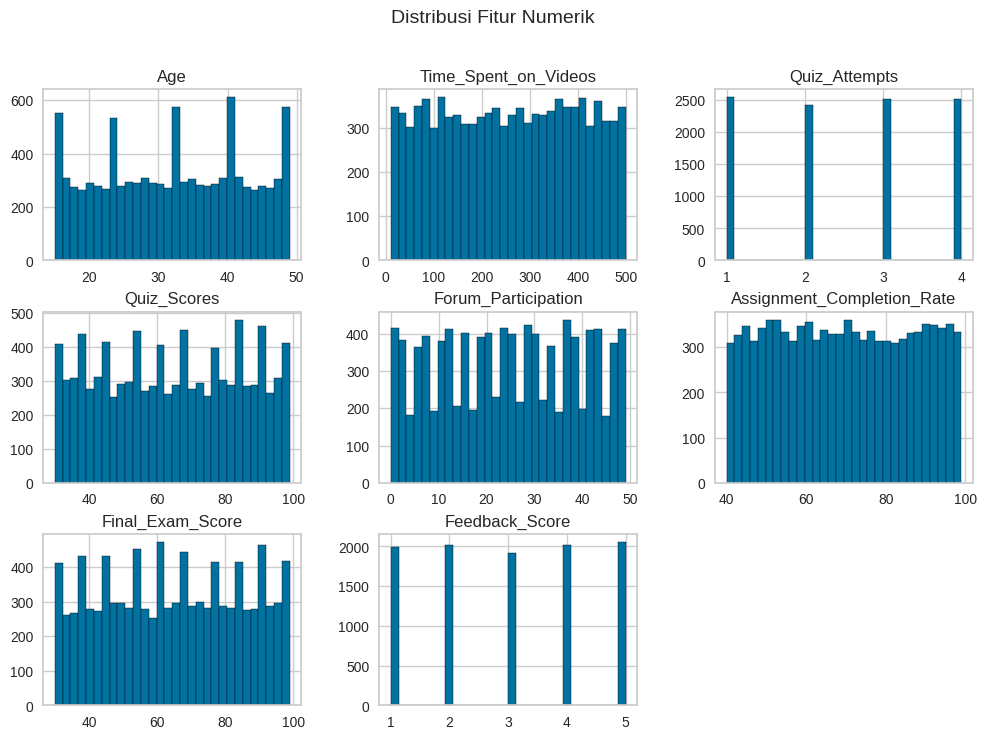

In [73]:
df.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Distribusi Fitur Numerik", fontsize=14)
plt.show()

### Boxplot untuk Deteksi Outlier

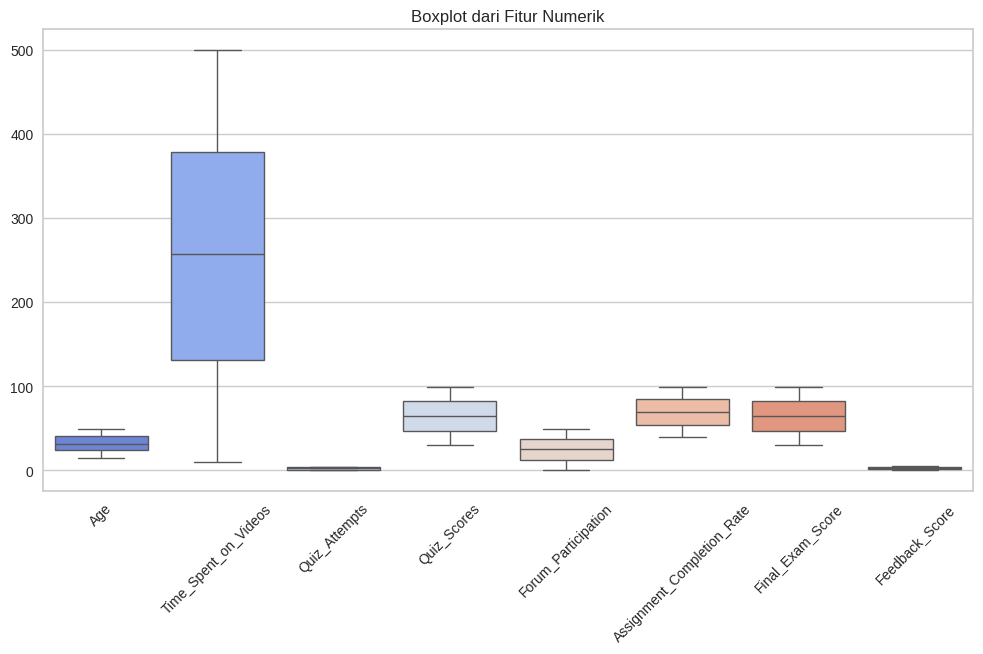

In [74]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Boxplot dari Fitur Numerik")
plt.show()

### Distribusi Setiap Fitur Numerik Secara Individual

#### Distribusi Usia

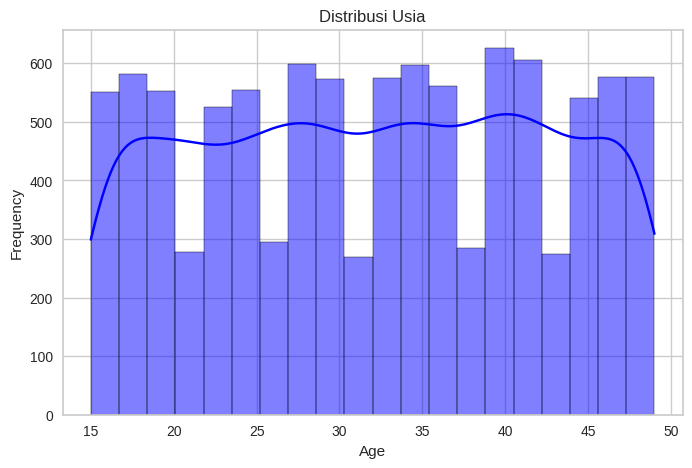

In [75]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Age"], bins=20, kde=True, color="blue")
plt.title("Distribusi Usia")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Waktu yang Dihabiskan Menonton Video

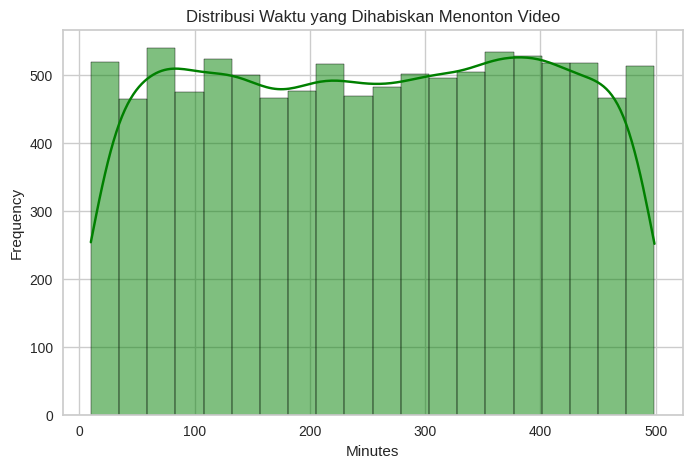

In [76]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Time_Spent_on_Videos"], bins=20, kde=True, color="green")
plt.title("Distribusi Waktu yang Dihabiskan Menonton Video")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Jumlah Percobaan Kuis

<ipython-input-77-17f10f8bf54d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Quiz_Attempts"], palette="pastel")


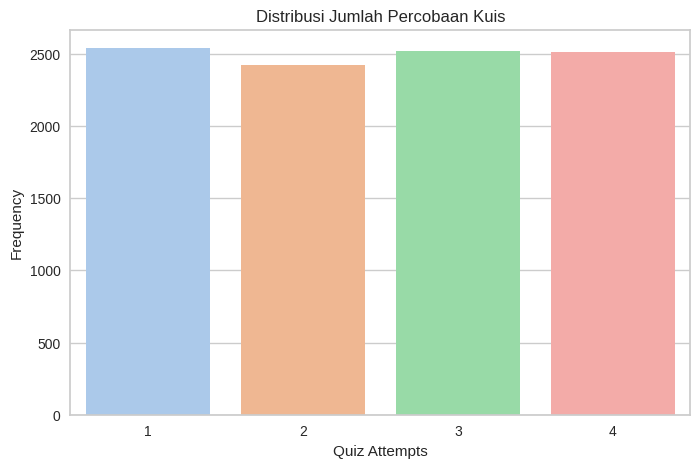

In [77]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Quiz_Attempts"], palette="pastel")
plt.title("Distribusi Jumlah Percobaan Kuis")
plt.xlabel("Quiz Attempts")
plt.ylabel("Frequency")
plt.show()

####Distribusi Skor Kuis

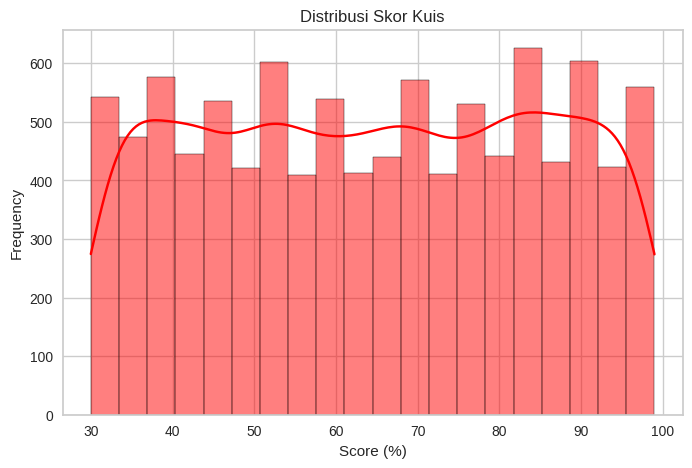

In [78]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Quiz_Scores"], bins=20, kde=True, color="red")
plt.title("Distribusi Skor Kuis")
plt.xlabel("Score (%)")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Partisipasi Forum

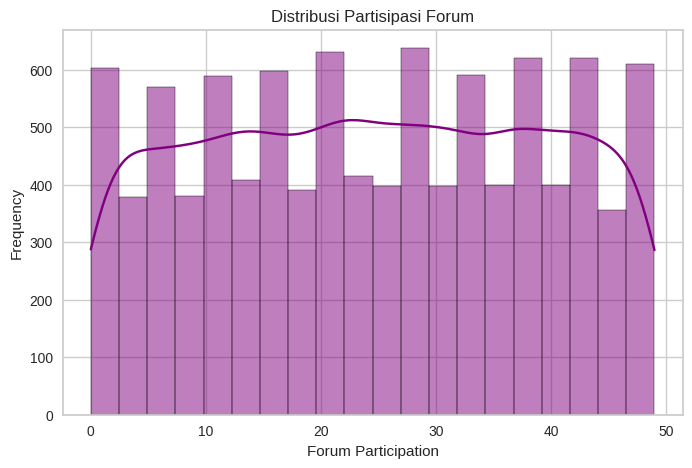

In [79]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Forum_Participation"], bins=20, kde=True, color="purple")
plt.title("Distribusi Partisipasi Forum")
plt.xlabel("Forum Participation")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Partisipasi Forum

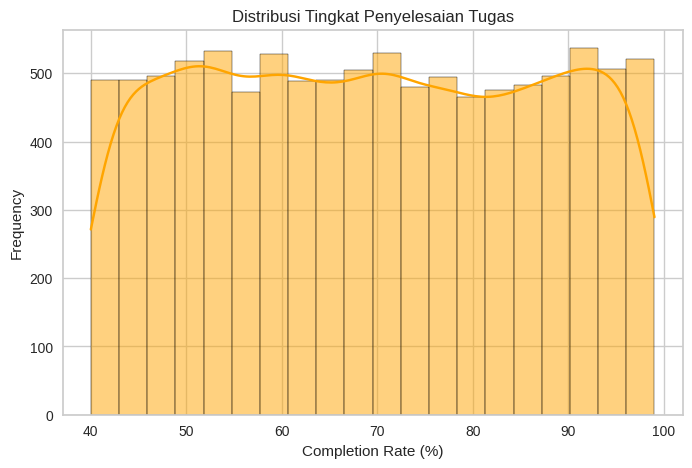

In [80]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Assignment_Completion_Rate"], bins=20, kde=True, color="orange")
plt.title("Distribusi Tingkat Penyelesaian Tugas")
plt.xlabel("Completion Rate (%)")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Skor Ujian Akhir

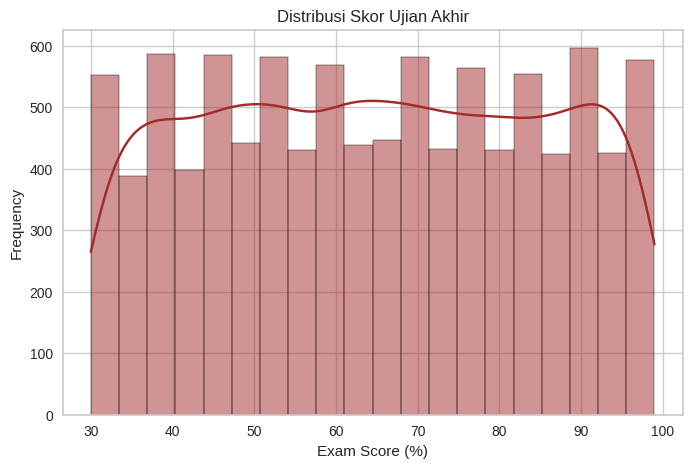

In [81]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Final_Exam_Score"], bins=20, kde=True, color="brown")
plt.title("Distribusi Skor Ujian Akhir")
plt.xlabel("Exam Score (%)")
plt.ylabel("Frequency")
plt.show()

#### Distribusi Skor Umpan Balik

<ipython-input-82-f3a666722558>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Feedback_Score"], palette="coolwarm")


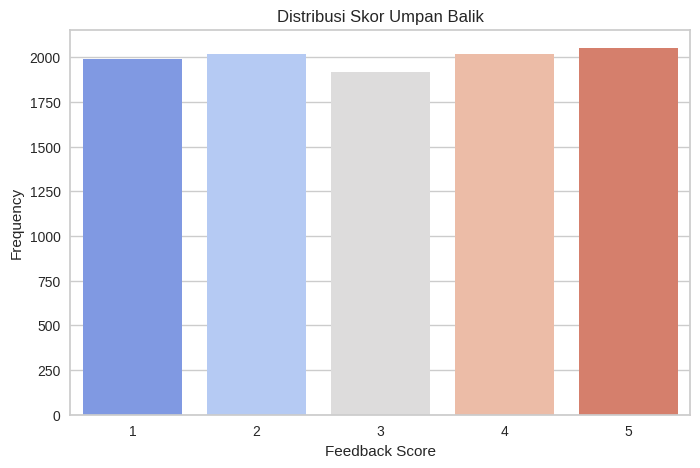

In [82]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Feedback_Score"], palette="coolwarm")
plt.title("Distribusi Skor Umpan Balik")
plt.xlabel("Feedback Score")
plt.ylabel("Frequency")
plt.show()

## Distribusi Fitur Kategorikal

Fitur kategorikal dalam dataset meliputi:

- Gender

- Education_Level

- Course_Name

- Engagement_Level

- Learning_Style

### Distribusi Gender

<ipython-input-83-4df845a318c5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Gender"], palette="pastel")


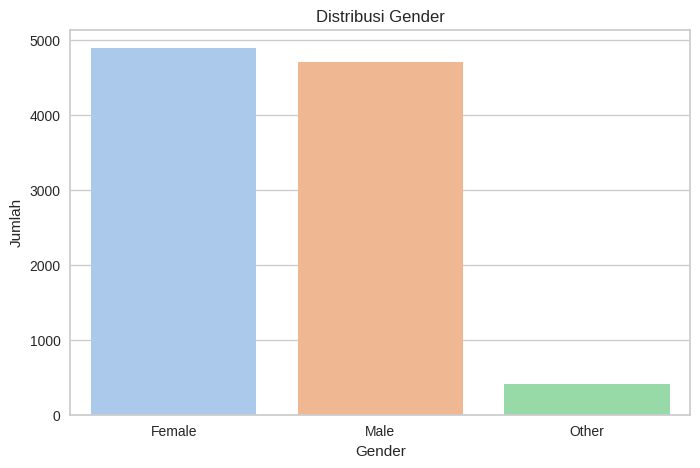

In [83]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Gender"], palette="pastel")
plt.title("Distribusi Gender")
plt.xlabel("Gender")
plt.ylabel("Jumlah")
plt.show()

### Distribusi Tingkat Pendidikan

<ipython-input-84-0010efb29ecd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Education_Level"], palette="muted")


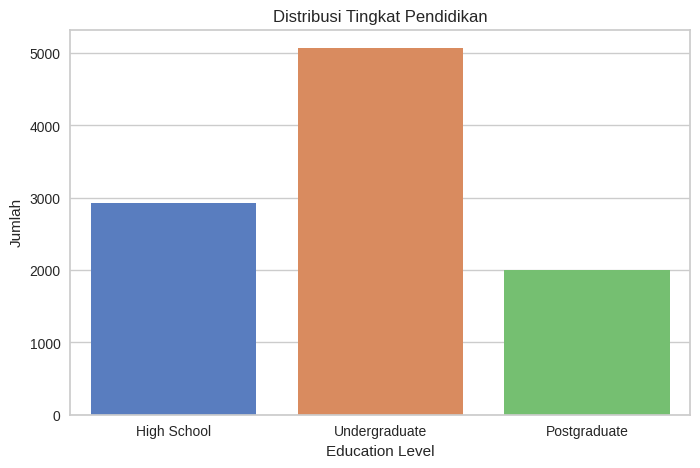

In [84]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Education_Level"], palette="muted")
plt.title("Distribusi Tingkat Pendidikan")
plt.xlabel("Education Level")
plt.ylabel("Jumlah")
plt.show()

### Distribusi Course yang Diambil

<ipython-input-85-7e4978259a5e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Course_Name"], palette="coolwarm")


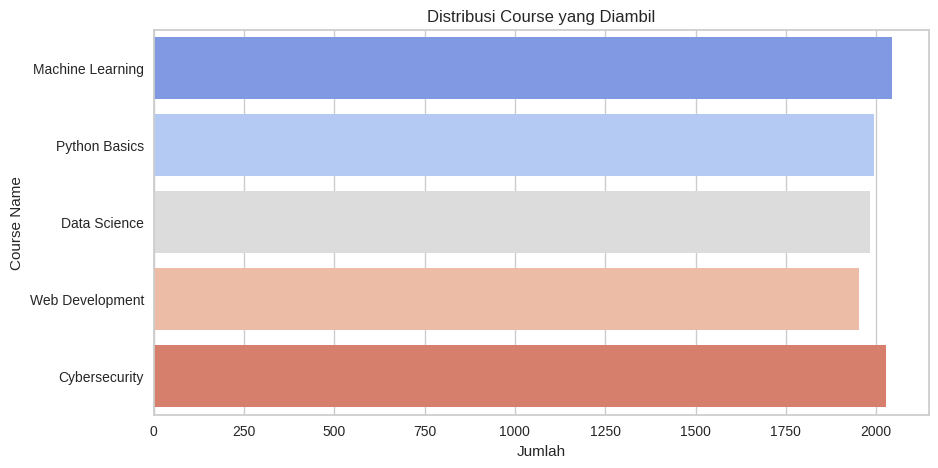

In [85]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df["Course_Name"], palette="coolwarm")
plt.title("Distribusi Course yang Diambil")
plt.xlabel("Jumlah")
plt.ylabel("Course Name")
plt.show()

### Distribusi Engagement Level

<ipython-input-86-7ba998854cbe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Engagement_Level"], palette="cool")


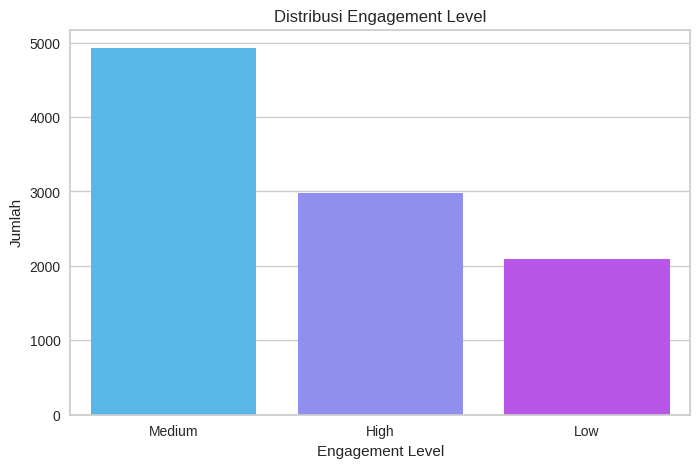

In [86]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Engagement_Level"], palette="cool")
plt.title("Distribusi Engagement Level")
plt.xlabel("Engagement Level")
plt.ylabel("Jumlah")
plt.show()

### Distribusi Learning Style

<ipython-input-87-5b256b7480b2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Learning_Style"], palette="coolwarm")


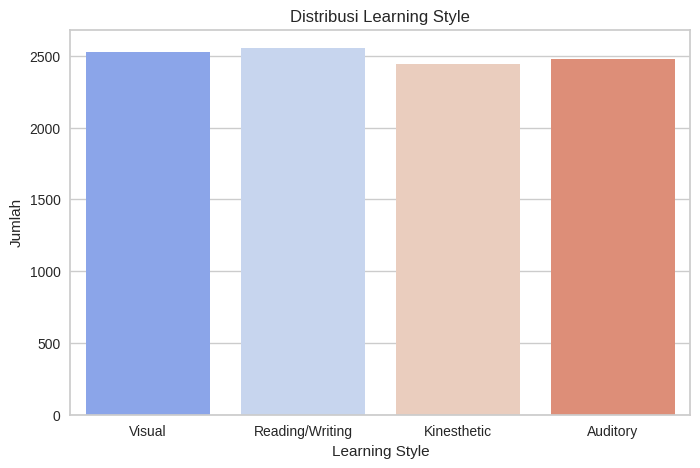

In [87]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Learning_Style"], palette="coolwarm")
plt.title("Distribusi Learning Style")
plt.xlabel("Learning Style")
plt.ylabel("Jumlah")
plt.show()

## Korelasi antar variabel

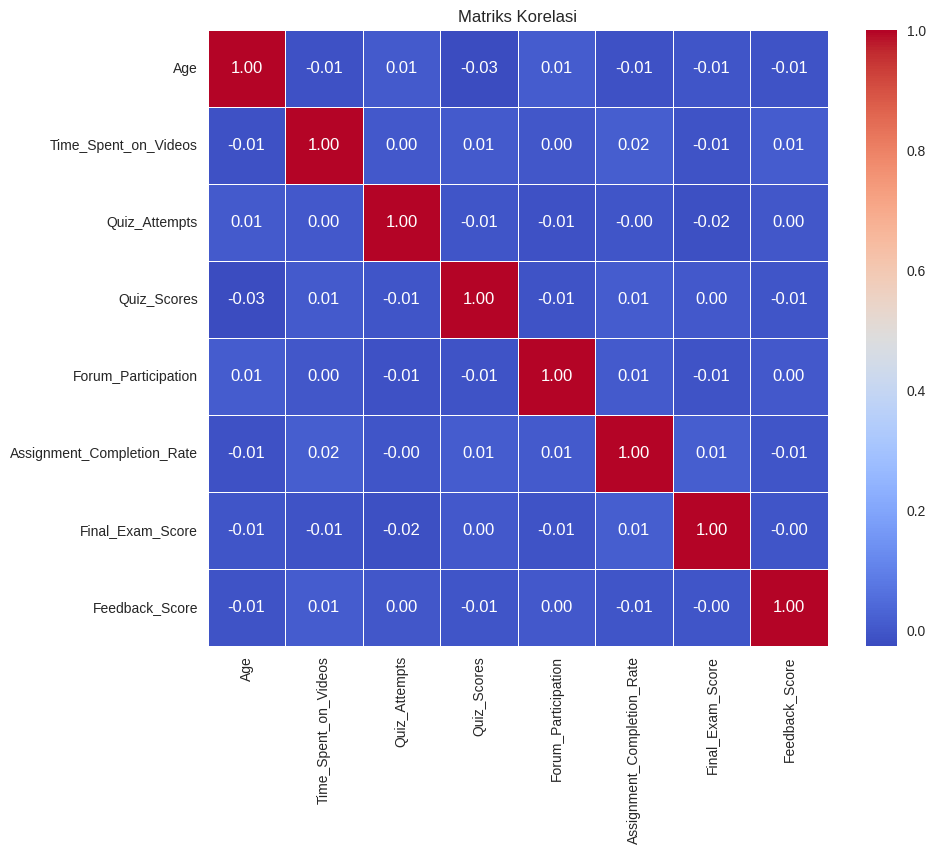

In [88]:
numerical_features = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriks Korelasi")
plt.show()

# **5. Data Preprocessing**

Tahap ini bertujuan untuk membersihkan, mempersiapkan, dan menyusun data agar siap digunakan dalam model clustering.

Tahapan Data Preprocessing:
- Menangani Missing Values
- Menghapus Data Duplikat
- Encoding Data Kategorikal
- Deteksi dan Penanganan Outlier
- Binning pada Fitur Tertentu
- Normalisasi atau Standarisasi Fitur Numerik

## Menangani Missing Values

In [89]:
print(df.isnull().sum())

Student_ID                    0
Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score                0
dtype: int64


Tidak ditemukan adanya missing values.

### Menghapus Data Duplikat

In [90]:
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Jumlah data duplikat: 0


Tidak ditemukan adanya data duplikat.

## Encoding Data Kategorikal

Fitur kategorikal yang perlu diubah menjadi numerik:

- Gender

- Education_Level

- Course_Name

- Engagement_Level

- Learning_Style

In [91]:
df = pd.get_dummies(df, columns=["Gender", "Education_Level", "Course_Name", "Engagement_Level", "Learning_Style"], drop_first=True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Student_ID                      10000 non-null  object
 1   Age                             10000 non-null  int64 
 2   Time_Spent_on_Videos            10000 non-null  int64 
 3   Quiz_Attempts                   10000 non-null  int64 
 4   Quiz_Scores                     10000 non-null  int64 
 5   Forum_Participation             10000 non-null  int64 
 6   Assignment_Completion_Rate      10000 non-null  int64 
 7   Final_Exam_Score                10000 non-null  int64 
 8   Feedback_Score                  10000 non-null  int64 
 9   Gender_Male                     10000 non-null  bool  
 10  Gender_Other                    10000 non-null  bool  
 11  Education_Level_Postgraduate    10000 non-null  bool  
 12  Education_Level_Undergraduate   10000 non-null 

## Deteksi dan Penanganan Outlier
Menggunakan Interquartile Range (IQR) untuk mendeteksi dan menghapus outlier pada fitur numerik:

In [93]:
# Pilih hanya kolom numerik
numerical_columns = df.select_dtypes(include=['number'])

# Hitung Q1 (25%) dan Q3 (75%) untuk setiap fitur numerik
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Identifikasi outlier: data yang berada di luar batas IQR
outlier_condition = (numerical_columns < (Q1 - 1.5 * IQR)) | (numerical_columns > (Q3 + 1.5 * IQR))
outliers = numerical_columns[outlier_condition.any(axis=1)]

# Jumlah outlier
num_outliers = len(outliers)
print(f"Jumlah outlier: {num_outliers}")

Jumlah outlier: 0


Tidak Terdeteksi adanya Outlier.

## Binning pada Fitur Tertentu
Beberapa fitur dapat dikelompokkan dalam kategori untuk analisis lebih lanjut:

###Binning pada Age (Kelompok Usia)
Mengubah usia ke dalam kategori:

- Teenager (15-20 tahun)

- Young Adult (21-30 tahun)

- Adult (31-40 tahun)

- Senior (41-50 tahun)

In [94]:
bins = [15, 20, 30, 40, 50]
labels = ["Teenager", "Young Adult", "Adult", "Senior"]
df["Age_Group"] = pd.cut(df["Age"], bins=bins, labels=labels)

### Binning pada Quiz_Scores dan Final_Exam_Score
Mengelompokkan performa ujian menjadi:

- Low (≤50%)

- Medium (51-75%)

- High (>75%)

In [95]:
bins = [0, 50, 75, 100]
labels = ["Low", "Medium", "High"]

df["Quiz_Performance"] = pd.cut(df["Quiz_Scores"], bins=bins, labels=labels)
df["Final_Exam_Performance"] = pd.cut(df["Final_Exam_Score"], bins=bins, labels=labels)

### Binning pada Time_Spent_on_Videos (Durasi Belajar)
Mengelompokkan waktu menonton video ke dalam kategori:

- Very Short (<100 menit)

- Short (100-200 menit)

- Medium (201-300 menit)

- Long (301-400 menit)

- Very Long (>400 menit)


In [96]:
bins = [0, 100, 200, 300, 400, 500]
labels = ["Very Short", "Short", "Medium", "Long", "Very Long"]
df["Video_Watching_Habit"] = pd.cut(df["Time_Spent_on_Videos"], bins=bins, labels=labels)

### Encoding Kategori Hasil Binning
Setelah binning, kita harus mengubah kategori ke dalam bentuk numerik agar bisa digunakan dalam clustering.

In [97]:
df = pd.get_dummies(df, columns=["Age_Group", "Quiz_Performance", "Final_Exam_Performance", "Video_Watching_Habit"], drop_first=True)

## Normalisasi atau Standarisasi Fitur Numerik
Clustering sangat bergantung pada skala data, sehingga kita menggunakan Min-Max Scaling untuk fitur numerik:

In [98]:
# Get numerical features from updated df
numerical_features = df.select_dtypes(include=['number']).columns

# Now use this updated list of numerical features for scaling
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Save scaler for later use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [99]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Student_ID                      10000 non-null  object 
 1   Age                             10000 non-null  float64
 2   Time_Spent_on_Videos            10000 non-null  float64
 3   Quiz_Attempts                   10000 non-null  float64
 4   Quiz_Scores                     10000 non-null  float64
 5   Forum_Participation             10000 non-null  float64
 6   Assignment_Completion_Rate      10000 non-null  float64
 7   Final_Exam_Score                10000 non-null  float64
 8   Feedback_Score                  10000 non-null  float64
 9   Gender_Male                     10000 non-null  bool   
 10  Gender_Other                    10000 non-null  bool   
 11  Education_Level_Postgraduate    10000 non-null  bool   
 12  Education_Level_Undergraduate   1

,Age,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Final_Exam_Score,Feedback_Score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.504050,0.501790,0.500167,0.501139,0.502371,0.500793,0.502855,0.503150
std,0.295960,0.289686,0.374214,0.294045,0.292455,0.294251,0.291252,0.355356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.264706,0.247444,0.000000,0.246377,0.244898,0.237288,0.246377,0.250000
50%,0.500000,0.505112,0.666667,0.507246,0.510204,0.491525,0.507246,0.500000
75%,0.764706,0.752556,1.000000,0.753623,0.755102,0.762712,0.753623,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **6. Pembangunan Model Clustering**

In [100]:
# Drop Student_ID karena tidak relevan
df_cluster = df.drop(columns=["Student_ID"])

## **a. Menentukan Jumlah Cluster Optimal**

### Elbow Method

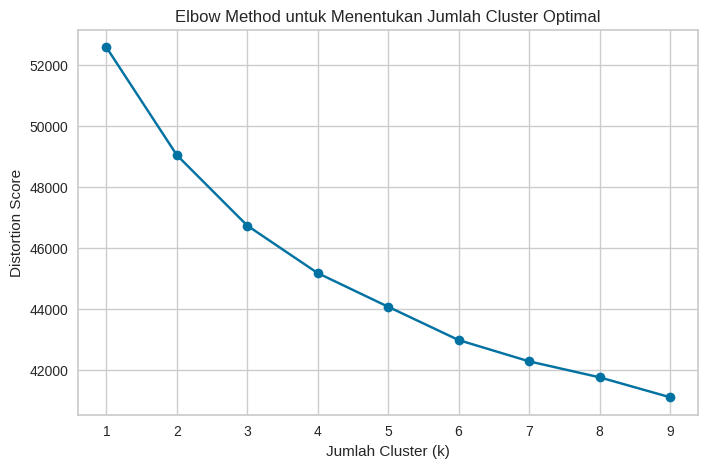

In [102]:
# Mencari jumlah cluster optimal dengan Elbow Method
distortions = []
K_range = range(1, 10)  # Coba dari 1 hingga 9 cluster

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster)
    distortions.append(kmeans.inertia_)  # Simpan distortion score

# Visualisasi Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, 'bo-')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Distortion Score")
plt.title("Elbow Method untuk Menentukan Jumlah Cluster Optimal")
plt.show()

**Elbow Method:**

- Distortion Score turun signifikan hingga k = 4, lalu melambat.

- Setelah 4, tambahan cluster tidak banyak mengurangi error.

- K = 4 adalah titik optimal sebelum diminishing returns

### Silhouette Score

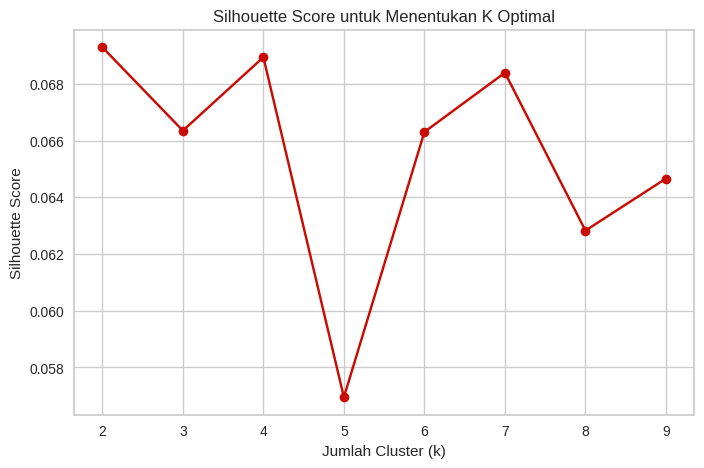

In [103]:
silhouette_scores = []

for k in range(2, 10):  # K-Means tidak bisa memakai k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, labels)
    silhouette_scores.append(score)

# Visualisasi Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, 'ro-')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score untuk Menentukan K Optimal")
plt.show()

**Silhouette Score**

- K = 4 memiliki skor tertinggi, menandakan pemisahan cluster yang baik.

- K = 5 mengalami penurunan drastis, menandakan pembagian yang buruk.

- Setelah k = 4, skor berfluktuasi, menunjukkan ketidakstabilan pemisahan.

**Kesimpulan: K = 4 adalah Pilihan Terbaik**

- Cukup granular tanpa terlalu kompleks.

- Pemisahan antar cluster Optimal.

- Hasil stabil dan mudah dianalisis.

## **c. Penerapan Model Clustering**

### K-Means

Silhouette Score K-Means: 0.1270060781228924


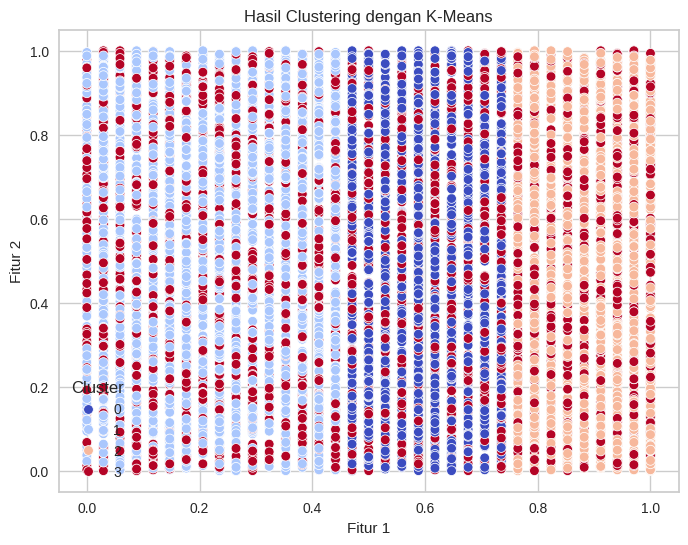

In [104]:
# Model K-Means dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=4, random_state=0)
df_cluster['Cluster_KMeans'] = kmeans.fit_predict(df_cluster)

# Hitung silhouette score K-Means
silhouette_kmeans = silhouette_score(df_cluster, df_cluster['Cluster_KMeans'])
print(f"Silhouette Score K-Means: {silhouette_kmeans}")

# Visualisasi hasil clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_cluster.iloc[:, 0], y=df_cluster.iloc[:, 1], hue=df_cluster['Cluster_KMeans'], palette='coolwarm')
plt.title("Hasil Clustering dengan K-Means")
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.legend(title="Cluster")
plt.show()

###DBSCAN

Silhouette Score DBSCAN: Tidak dapat dihitung (hanya 1 cluster)


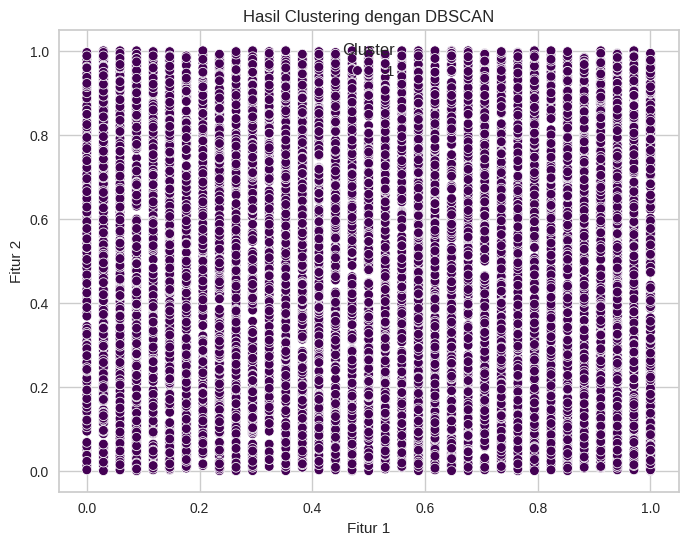

In [105]:
# Model DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_cluster['Cluster_DBSCAN'] = dbscan.fit_predict(df_cluster)

# Evaluasi Silhouette Score (hanya jika lebih dari 1 cluster)
if len(set(df_cluster['Cluster_DBSCAN'])) > 1:
    silhouette_dbscan = silhouette_score(df_cluster, df_cluster['Cluster_DBSCAN'])
else:
    silhouette_dbscan = "Tidak dapat dihitung (hanya 1 cluster)"

print(f"Silhouette Score DBSCAN: {silhouette_dbscan}")

# Visualisasi hasil DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_cluster.iloc[:, 0], y=df_cluster.iloc[:, 1], hue=df_cluster['Cluster_DBSCAN'], palette='viridis')
plt.title("Hasil Clustering dengan DBSCAN")
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.legend(title="Cluster")
plt.show()

### Agglomerative

Silhouette Score Agglomerative: 0.2119730038523352


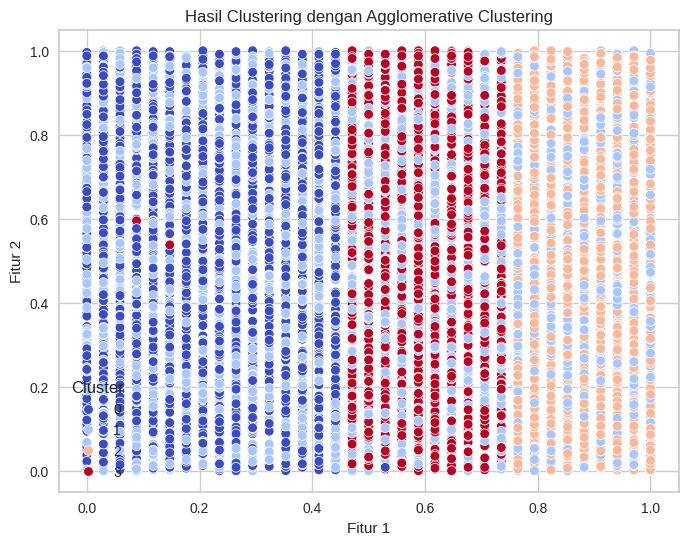

In [106]:
# Model Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_cluster['Cluster_Agglo'] = agglo.fit_predict(df_cluster)

# Hitung silhouette score
silhouette_agglo = silhouette_score(df_cluster, df_cluster['Cluster_Agglo'])
print(f"Silhouette Score Agglomerative: {silhouette_agglo}")

# Visualisasi hasil Agglomerative Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_cluster.iloc[:, 0], y=df_cluster.iloc[:, 1], hue=df_cluster['Cluster_Agglo'], palette='coolwarm')
plt.title("Hasil Clustering dengan Agglomerative Clustering")
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.legend(title="Cluster")
plt.show()

### Perbandingan Hasil Algoritma

  Metode Clustering  Silhouette Score
0           K-Means          0.127006
1            DBSCAN               NaN
2     Agglomerative          0.211973


<ipython-input-107-adf551c8935a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metode Clustering", y="Silhouette Score", data=silhouette_df, palette="coolwarm")


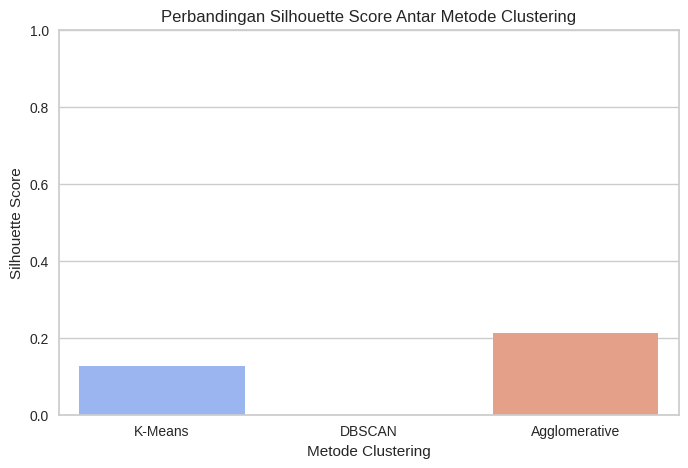

In [107]:
# Buat dictionary untuk menyimpan hasil silhouette score
silhouette_scores = {
    "K-Means": silhouette_kmeans,
    "DBSCAN": silhouette_dbscan if isinstance(silhouette_dbscan, float) else None,
    "Agglomerative": silhouette_agglo
}

# Konversi ke DataFrame
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=["Metode Clustering", "Silhouette Score"])

# Tampilkan tabel
print(silhouette_df)

# Visualisasi hasil dengan barplot
plt.figure(figsize=(8, 5))
sns.barplot(x="Metode Clustering", y="Silhouette Score", data=silhouette_df, palette="coolwarm")
plt.title("Perbandingan Silhouette Score Antar Metode Clustering")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)  # Nilai Silhouette Score berkisar antara -1 hingga 1
plt.show()

Karena Agglomeratice memiliki Silhouette Score tertinggi (0.211973) dibandingkan metode lain, kita akan melakukan Feature Selection berdasarkan hasil clustering Agglomerative untuk meningkatkan kualitas klaster.

## **d. Feature Selection**

In [109]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             10000 non-null  float64
 1   Time_Spent_on_Videos            10000 non-null  float64
 2   Quiz_Attempts                   10000 non-null  float64
 3   Quiz_Scores                     10000 non-null  float64
 4   Forum_Participation             10000 non-null  float64
 5   Assignment_Completion_Rate      10000 non-null  float64
 6   Final_Exam_Score                10000 non-null  float64
 7   Feedback_Score                  10000 non-null  float64
 8   Gender_Male                     10000 non-null  bool   
 9   Gender_Other                    10000 non-null  bool   
 10  Education_Level_Postgraduate    10000 non-null  bool   
 11  Education_Level_Undergraduate   10000 non-null  bool   
 12  Course_Name_Data Science        1

Hapus Kolom Hasil Clustering Selain Cluster_Agglo

In [110]:
# Simpan hanya fitur asli dan Cluster_KMeans
df_cluster = df_cluster.drop(columns=['Cluster_DBSCAN', 'Cluster_KMeans'], errors='ignore')

# Cek kembali struktur data
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             10000 non-null  float64
 1   Time_Spent_on_Videos            10000 non-null  float64
 2   Quiz_Attempts                   10000 non-null  float64
 3   Quiz_Scores                     10000 non-null  float64
 4   Forum_Participation             10000 non-null  float64
 5   Assignment_Completion_Rate      10000 non-null  float64
 6   Final_Exam_Score                10000 non-null  float64
 7   Feedback_Score                  10000 non-null  float64
 8   Gender_Male                     10000 non-null  bool   
 9   Gender_Other                    10000 non-null  bool   
 10  Education_Level_Postgraduate    10000 non-null  bool   
 11  Education_Level_Undergraduate   10000 non-null  bool   
 12  Course_Name_Data Science        1

### Analisis Pengaruh Fitur terhadap Cluster

In [111]:
# Pisahkan fitur dan target
X = df_cluster.drop(columns=['Cluster_Agglo'])  # Semua fitur kecuali hasil clustering
y = df_cluster['Cluster_Agglo']  # Target

# Hitung F-Score
f_scores, _ = f_classif(X, y)

# Buat DataFrame untuk menampilkan hasil F-Score
feature_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})

# Urutkan dari F-Score terbesar ke terkecil
feature_scores = feature_scores.sort_values(by='F-Score', ascending=False)

# Tampilkan hasil
print(feature_scores)

                           Feature       F-Score
27     Final_Exam_Performance_High  7.500342e+06
6                 Final_Exam_Score  6.946683e+03
23                Age_Group_Senior  6.404869e+03
22                 Age_Group_Adult  6.110582e+03
0                              Age  4.288157e+03
21           Age_Group_Young Adult  1.544491e+03
26   Final_Exam_Performance_Medium  1.404766e+03
2                    Quiz_Attempts  3.322633e+00
8                      Gender_Male  2.445263e+00
3                      Quiz_Scores  2.397822e+00
5       Assignment_Completion_Rate  2.135013e+00
25           Quiz_Performance_High  2.082191e+00
28      Video_Watching_Habit_Short  2.051439e+00
17         Engagement_Level_Medium  1.896850e+00
1             Time_Spent_on_Videos  1.810774e+00
29     Video_Watching_Habit_Medium  1.663372e+00
11   Education_Level_Undergraduate  1.587416e+00
19  Learning_Style_Reading/Writing  1.316605e+00
20           Learning_Style_Visual  1.135682e+00
12        Course_Nam

Fitur Usia (Age, Age_Group_Adult, Age_Group_Senior) dan Performa Ujian (Final_Exam_Score, Final_Exam_Performance_High) menunjukkan korelasi tinggi dengan hasil clustering. Hal ini logis karena usia bisa menentukan pola belajar, sedangkan performa ujian mencerminkan tingkat keterlibatan dalam kursus.

Untuk meminimalkan redundansi, kita hanya memilih Age, Final_Exam_Score, dan Final_Exam_Performance_High agar tidak terjadi multikolinearitas dengan variabel kategori seperti Age_Group_Adult.

### **Pilih Fitur yang paling Berpengaruh**

In [124]:
# Pilih fitur tambahan berdasarkan analisis F-score
selected_features = [
    "Age",
    "Final_Exam_Score",
    "Final_Exam_Performance_High"
]
# Buat dataset baru dengan fitur terpilih
df_selected = df_cluster[selected_features + ['Cluster_Agglo']]

# Tampilkan data setelah feature selection
print(df_selected.head())


        Age  Final_Exam_Score  Final_Exam_Performance_High  Cluster_Agglo
0  0.000000          0.304348                        False              0
1  1.000000          0.898551                         True              1
2  0.147059          0.217391                        False              0
3  0.647059          0.420290                        False              3
4  0.558824          0.913043                         True              1


### **Clustering Ulang dengan Fitur Terpilih**

In [125]:
# Clustering dengan Agglomerative
agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_selected["Cluster_Agglo"] = agglo.fit_predict(df_selected[selected_features])

# Hitung Silhouette Score
silhouette_avg = silhouette_score(df_selected[selected_features], df_selected["Cluster_Agglo"])
print(f"Silhouette Score setelah Iterasi: {silhouette_avg}")

# Lihat hasil clustering
print(df_selected.groupby("Cluster_Agglo").mean())

<ipython-input-125-2e7d3ac07b5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["Cluster_Agglo"] = agglo.fit_predict(df_selected[selected_features])


Silhouette Score setelah Iterasi: 0.42535063440985577
                    Age  Final_Exam_Score  Final_Exam_Performance_High
Cluster_Agglo                                                         
0              0.722691          0.279454                          0.0
1              0.687047          0.824016                          1.0
2              0.252142          0.388244                          0.0
3              0.180219          0.854398                          1.0


**Interpretasi Silhouette Score:**
- Sebelum Feature Selection: Silhouette Score 0.208238

- Setelah Feature Selection: Silhouette Score 0.425350

Hasil ini menunjukkan bahwa feature selection berhasil meningkatkan kualitas clustering, karena nilai Silhouette Score semakin mendekati 1, yang berarti cluster lebih terpisah dengan baik.

## **e. Visualisasi Hasil Clustering**

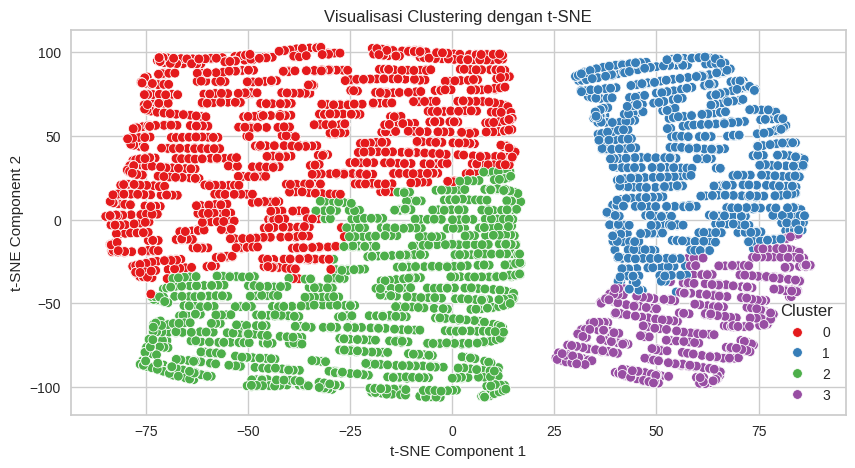

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


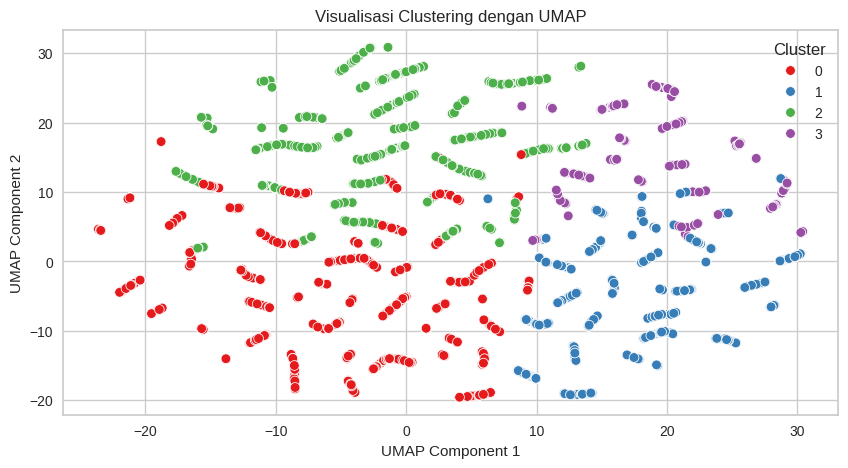

In [127]:
# Visualisasi dengan t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(df_selected[selected_features])

plt.figure(figsize=(10, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df_selected['Cluster_Agglo'], palette='Set1')
plt.title("Visualisasi Clustering dengan t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

# Visualisasi dengan UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(df_selected[selected_features])

plt.figure(figsize=(10, 5))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=df_selected['Cluster_Agglo'], palette='Set1')
plt.title("Visualisasi Clustering dengan UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Cluster")
plt.show()


## **f. Analisis dan Interpretasi Hasil Cluster**

### Menambahkan Label Cluster ke DataFrame

In [130]:
df_selected['Cluster_Selected'] = agglo.fit_predict(df_selected)

<ipython-input-130-a8688a88ee75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Cluster_Selected'] = agglo.fit_predict(df_selected)


###**Inverse Transform untuk Data Kategorikal**

In [131]:
print(df_selected.columns)

Index(['Age', 'Final_Exam_Score', 'Final_Exam_Performance_High',
       'Cluster_Agglo', 'Cluster_Selected'],
      dtype='object')


In [132]:
df_selected.drop(columns=['Cluster_Agglo'], inplace=True)

<ipython-input-132-18c560d86603>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(columns=['Cluster_Agglo'], inplace=True)


In [133]:
df_selected['Final_Exam_Performance'] = df_selected['Final_Exam_Performance_High'].apply(lambda x: 'High' if x == 1 else 'Low')

<ipython-input-133-ed88803d1a18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Final_Exam_Performance'] = df_selected['Final_Exam_Performance_High'].apply(lambda x: 'High' if x == 1 else 'Low')


In [134]:
df_selected['Final_Exam_Performance'] = df_selected[['Final_Exam_Performance_High']].idxmax(axis=1).str.replace('Final_Exam_Performance_', '')

<ipython-input-134-aa73c901fc4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Final_Exam_Performance'] = df_selected[['Final_Exam_Performance_High']].idxmax(axis=1).str.replace('Final_Exam_Performance_', '')


In [135]:
df_selected.head()

,Age,Final_Exam_Score,Final_Exam_Performance_High,Cluster_Selected,Final_Exam_Performance
0,0.000000,0.304348,False,3,High
1,1.000000,0.898551,True,2,High
2,0.147059,0.217391,False,3,High
3,0.647059,0.420290,False,1,High
4,0.558824,0.913043,True,2,High


###  **Inverse Transform untuk Data Numerik**

In [136]:
print(df_selected.columns)

Index(['Age', 'Final_Exam_Score', 'Final_Exam_Performance_High',
       'Cluster_Selected', 'Final_Exam_Performance'],
      dtype='object')


In [137]:
import joblib

# Load scaler yang telah disimpan
scaler = joblib.load("scaler.pkl")

# Pastikan semua fitur numerik kembali ke skala aslinya
df[numerical_features] = scaler.inverse_transform(df[numerical_features])

# Sekarang df_selected mengambil data yang sudah di-inverse
df_selected['Final_Exam_Score'] = df['Final_Exam_Score']
df_selected['Age'] = df['Age']


<ipython-input-137-52dcd003fc3a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Final_Exam_Score'] = df['Final_Exam_Score']
<ipython-input-137-52dcd003fc3a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Age'] = df['Age']


In [138]:
df_selected.describe()

,Age,Final_Exam_Score,Cluster_Selected
count,10000.000000,10000.000000,10000.000000
mean,32.137700,64.697000,1.540900
std,10.062647,20.096417,1.096562
min,15.000000,30.000000,0.000000
25%,24.000000,47.000000,1.000000
50%,32.000000,65.000000,1.000000
75%,41.000000,82.000000,3.000000
max,49.000000,99.000000,3.000000


### Analisis Karakteristik Tiap Cluster

In [139]:
# Convert 'Final_Exam_Performance' to numeric if needed
df_selected['Final_Exam_Performance'] = pd.to_numeric(df_selected['Final_Exam_Performance'], errors='coerce') #This will convert to numeric and replace non-numeric values to NaN. You might need to impute/replace them if you want.

# Then, calculate the cluster summary
cluster_summary = df_selected.groupby('Cluster_Selected').mean()
print(cluster_summary)

                        Age  Final_Exam_Score  Final_Exam_Performance_High  \
Cluster_Selected                                                             
0                 25.498589         83.172154                     0.800094   
1                 41.455917         50.686892                     0.000000   
2                 38.055185         76.766800                     0.765465   
3                 21.934191         55.390318                     0.000000   

                  Final_Exam_Performance  
Cluster_Selected                          
0                                    NaN  
1                                    NaN  
2                                    NaN  
3                                    NaN  


<ipython-input-139-8be90e54b318>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Final_Exam_Performance'] = pd.to_numeric(df_selected['Final_Exam_Performance'], errors='coerce') #This will convert to numeric and replace non-numeric values to NaN. You might need to impute/replace them if you want.


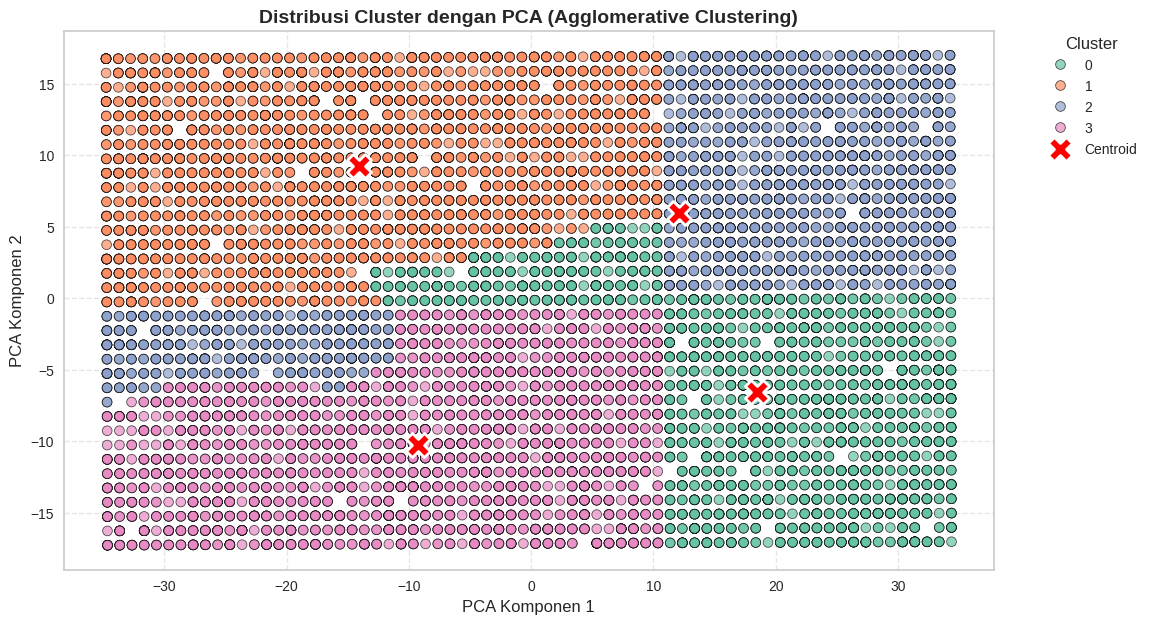

In [146]:
# Ukuran plot lebih besar
plt.figure(figsize=(12, 7))

# Scatter plot dengan transparansi agar tidak terlalu padat
scatter = sns.scatterplot(data=df_selected, x="PCA1", y="PCA2", hue="Cluster_Selected",
                          palette="Set2", alpha=0.7, edgecolor='black')

# Tambahkan Centroid dengan ukuran lebih besar dan outline putih
plt.scatter(centroids['PCA1'], centroids['PCA2'],
            color='red', marker='X', s=300, edgecolors='white', linewidth=2, label='Centroid')

# Tambahkan grid agar lebih rapi
plt.grid(True, linestyle="--", alpha=0.5)

# Tambahkan judul dan label sumbu
plt.title("Distribusi Cluster dengan PCA (Agglomerative Clustering)", fontsize=14, fontweight='bold')
plt.xlabel("PCA Komponen 1", fontsize=12)
plt.ylabel("PCA Komponen 2", fontsize=12)

# Tambahkan legenda di luar plot
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.show()


### Analisis Cluster

**Cluster 0:**
- Rata-rata Usia: 25.50 tahun

- Rata-rata Nilai Ujian Akhir: 83.17

- Final Exam Performance (High): 80%

**Analisis:**

Cluster ini didominasi oleh peserta yang relatif muda dengan skor ujian akhir yang tinggi. Sebagian besar dari mereka memiliki kinerja ujian akhir yang sangat baik. Ini bisa menunjukkan bahwa kelompok ini lebih serius atau memiliki pemahaman yang lebih baik terhadap materi kursus.


**Cluster 1:**
- Rata-rata Usia: 41.46 tahun

- Rata-rata Nilai Ujian Akhir: 50.69

- Final Exam Performance (High): 0%

**Analisis:**

Cluster ini terdiri dari peserta yang lebih tua dengan nilai ujian akhir yang lebih rendah. Tidak ada anggota dalam cluster ini yang memiliki performa tinggi dalam ujian akhir, yang mungkin menunjukkan bahwa mereka menghadapi lebih banyak kesulitan dalam menyerap materi atau memiliki keterbatasan waktu dalam belajar.


**Cluster 2:**
- Rata-rata Usia: 38.06 tahun

- Rata-rata Nilai Ujian Akhir: 76.77

- Final Exam Performance (High): 76.55%

**Analisis:**

Kelompok ini terdiri dari peserta dengan usia yang cukup matang tetapi masih menunjukkan performa ujian yang tinggi. Ini bisa menunjukkan bahwa mereka memiliki motivasi belajar yang tinggi meskipun bukan dari kelompok usia muda.


**Cluster 3:**
- Rata-rata Usia: 21.93 tahun

- Rata-rata Nilai Ujian Akhir: 55.39

- Final Exam Performance (High): 0%

**Analisis:**

Cluster ini berisi peserta yang lebih muda tetapi dengan performa akademik yang lebih rendah. Meskipun mereka lebih muda, kemungkinan mereka kurang serius dalam belajar atau memiliki strategi belajar yang kurang efektif dibandingkan dengan Cluster 0.



# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [147]:
df_selected.head()

,Age,Final_Exam_Score,Final_Exam_Performance_High,Cluster_Selected,Final_Exam_Performance,PCA1,PCA2
0,15.0,51.0,False,3,NaN,-13.636046,-17.186239
1,49.0,92.0,True,2,NaN,27.242939,16.959165
2,20.0,45.0,False,3,NaN,-19.653767,-12.207580
3,37.0,59.0,False,1,NaN,-5.714233,4.842036
4,34.0,93.0,True,2,NaN,28.296207,1.962811


In [148]:
df_selected.drop(columns=["Final_Exam_Performance", "PCA1", "PCA2"], inplace=True)
df_selected.to_csv("clustered_data_for_classification.csv", index=False)

<ipython-input-148-123d43d6c2be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(columns=["Final_Exam_Performance", "PCA1", "PCA2"], inplace=True)
